In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")
from numpy.fft import rfft2, irfft2, ifftshift
from scipy.signal import fftconvolve
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
import cv2
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from astropy.nddata import Cutout2D
import gc

In [3]:
def find_noise_square(image, box_size=50, margin=3):
    """
    Automatically find a square region with low signal (noise-dominated).
    image: 2D array
    box_size: side of the square region (pixels)
    margin: exclude edges
    threshold: how many sigma above the median to consider as "source"
    returns: (y0, x0, y1, x1) slice indices of best noise square
    """
    img = np.asarray(image, float)
    h, w = img.shape

    # smooth absolute value to find low-variance zones
    local_mean = uniform_filter(img, size=box_size)
    local_var = uniform_filter(img**2, size=box_size) - local_mean**2
    local_std = np.sqrt(np.maximum(local_var, 0))

    # exclude borders
    local_std[:margin, :] = np.inf
    local_std[-margin:, :] = np.inf
    local_std[:, :margin] = np.inf
    local_std[:, -margin:] = np.inf

    # pick minimum std region (least structured)
    cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

    # ensure square fits inside image
    half = box_size // 2
    y0 = max(0, cy - half)
    x0 = max(0, cx - half)
    y1 = min(h, y0 + box_size)
    x1 = min(w, x0 + box_size)

    return image[y0:y1, x0:x1]


def estimate_sigma(noise_image, weight, maxlag):
    local_covariance = covariance_fft2d(noise_image, maxlag)
    variance = weighted_variance_lag(weight, local_covariance, maxlag)
    return np.sqrt(variance)

def covariance_fft2d(image, maxlag):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)

    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)

    cy, cx = h//2, w//2
    window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
    return window


# @njit
def weighted_variance_lag(s, C_local, max_lag):
    H, W = s.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = s[y0:y1, x0:x1]
            s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

# @njit(fastmath=True)
def gaussian_1d(n, center, sigma):
    x = np.arange(n, dtype=float)
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def gaussian_weight(height, width, xc=0, yc=0, a=1):
    gx = gaussian_1d(width,  xc, a)
    gy = gaussian_1d(height, yc, a)

    weight = gy[:, None] * gx[None, :]
    weight /= weight.sum()
    return weight

def prepare_wiener_psf(psf, image_shape, K=0.0, dtype=np.float64):
    """
    Precompute PSF FFT terms for Wiener deconvolution.
    """

    psf = psf[::-1, ::-1].astype(dtype, copy=False)

    pad_shape = (
        image_shape[0] + psf.shape[0] - 1,
        image_shape[1] + psf.shape[1] - 1,
    )

    psf_padded = np.zeros(pad_shape, dtype=dtype)
    y0 = pad_shape[0] // 2 - psf.shape[0] // 2
    x0 = pad_shape[1] // 2 - psf.shape[1] // 2
    psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

    H = rfft2(ifftshift(psf_padded))
    H_conj = np.conj(H)
    denom = (H * H_conj) + K

    return {
        "H_conj": H_conj,
        "denom": denom,
        "pad_shape": pad_shape,
        "image_shape": image_shape,
    }

def wiener_deconvolution_fast(weight, psf_cache, dtype=np.float64):
    """
    Fast Wiener deconvolution using cached PSF FFT data.
    """

    weight = weight.astype(dtype, copy=False)
    W = rfft2(weight, psf_cache["pad_shape"])
    F = psf_cache["H_conj"] * W / psf_cache["denom"]
    result = irfft2(F, psf_cache["pad_shape"])

    h, w = psf_cache["image_shape"]
    return result[:h, :w]

def calculate_gaap_flux(image, psf_cache, weight, centers):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0]

    valid = np.isfinite(xs) & np.isfinite(ys)
    measured_F = np.full(len(centers), np.nan, dtype=np.float32)
    measured_F[valid] = map_coordinates(flux_map, [ys[valid], xs[valid]], order=1)

    return measured_F, weight_rescale


def gaussian_2d(xy, amplitude, sigma, x0, y0):
    x, y = xy
    r_2 = (x - x0)**2 + (y - y0)**2
    g = amplitude * np.exp(
        -r_2/(2*sigma**2)
    )
    return g.ravel()

def padded_cutout_with_center(image, cx, cy, size):
    """
    Extract a fixed-size cutout centered on (cy, cx).
    Pads with zeros when the cutout extends beyond the image.

    Returns
    -------
    cutout : (size, size) array
    (cy_c, cx_c) : subpixel center in cutout coordinates
    """

    h, w = image.shape
    half = size // 2

    # Integer anchor
    iy = int(np.floor(cy))
    ix = int(np.floor(cx))

    # Desired bounds in image coordinates
    y0 = iy - half
    x0 = ix - half
    y1 = y0 + size
    x1 = x0 + size

    # Overlap with image
    iy0 = max(0, y0)
    ix0 = max(0, x0)
    iy1 = min(h, y1)
    ix1 = min(w, x1)

    # Corresponding region in cutout coordinates
    cy0 = iy0 - y0
    cx0 = ix0 - x0
    cy1 = cy0 + (iy1 - iy0)
    cx1 = cx0 + (ix1 - ix0)

    # Allocate cutout
    cutout = np.zeros((size, size), dtype=image.dtype)

    # Insert image data
    cutout[cy0:cy1, cx0:cx1] = image[iy0:iy1, ix0:ix1]

    # Center in cutout coordinates
    cy_c = cy - y0
    cx_c = cx - x0

    return cutout, (cx_c, cy_c)

def create_psf(
    image: np.ndarray,
    catalog: Table,
    psf_size: int,
    window_size: float = 0.1,
    lower_percentile: float = 98.0,
    upper_percentile: float = 99.9,
    increase_window_factor: float = 2,
    minimum_log_flux=8,
    plot_chimney: bool = False,
    plot_psf: bool = False,
) -> np.ndarray:
    """
    Create a point spread function (PSF) using saturated stars identified in a catalog.

    Args:
        image (np.ndarray): 2D image array.
        catalog (Table): Source catalog containing star positions (must include at least x, y).
        psf_size (int): Final PSF cutout size in pixels.
        window_size (float, optional): Initial window size factor used around saturated stars. Defaults to 0.1.
        lower_percentile (float, optional): Lower percentile for saturation thresholding. Defaults to 98.0.
        upper_percentile (float, optional): Upper percentile for saturation thresholding. Defaults to 99.9.
        increase_window_factor (float, optional): Factor by which the window may grow if needed. Defaults to 2.
        plot_chimney (bool, optional): If True, plot each star cutout (chimney plot). Defaults to False.
        plot_psf (bool, optional): If True, plot the final PSF image. Defaults to False.

    Returns:
        np.ndarray: The computed PSF image with shape (psf_size, psf_size).
    """
    # Opening the flux and flux radius
    log_flux_radius = np.log(catalog["FLUX_RADIUS"])
    log_flux = np.log(catalog["FLUX_AUTO"])
    mask = np.isfinite(log_flux_radius) & np.isfinite(log_flux)

    # Calculate the flux radius that has the highest total flux within a window size
    maximum_flux = -np.inf
    center_maximum = -np.inf
    for window_center in np.linspace(min(log_flux_radius[mask]), max(log_flux_radius[mask]), 100):
        # Select region around window center
        new_mask = (
            np.isfinite(log_flux_radius)
            & np.isfinite(log_flux)
            & (log_flux_radius > window_center - window_size)
            & (log_flux_radius < window_center + window_size)
            & (log_flux > minimum_log_flux)
        )

        # Check if the total flux in region is maximum
        if np.sum(log_flux[new_mask]) > maximum_flux:
            maximum_flux = np.sum(log_flux[new_mask])
            center_maximum = window_center
    
    # Select all the sources in the found chimney
    selection_mask = (
        np.isfinite(log_flux_radius)
        & np.isfinite(log_flux)
        & (log_flux_radius > center_maximum - increase_window_factor * window_size)
        & (log_flux_radius < center_maximum + increase_window_factor * window_size)
    )

    # Make a selection of the sources in the chinmey
    percentiles = np.percentile(log_flux[selection_mask], [lower_percentile, upper_percentile])
    selection_mask = (
        np.isfinite(log_flux_radius)
        & np.isfinite(log_flux)
        & (log_flux_radius > center_maximum - increase_window_factor * window_size)
        & (log_flux_radius < center_maximum + increase_window_factor * window_size)
        & (log_flux > percentiles[0])
        & (log_flux < percentiles[1])
    )

    # Plot the flux, flux radius plot with the selected sources highlighted
    if plot_chimney:
        plt.scatter(log_flux_radius[mask], log_flux[mask], color="b", s=1, alpha=0.5, label="Sources")
        plt.scatter(
            log_flux_radius[selection_mask],
            log_flux[selection_mask],
            s=1,
            alpha=0.5,
            color="r",
            label="Selected Sources for PSF",
        )
        plt.xlabel("log(flux radius)")
        plt.ylabel("log flux")
        plt.legend()
        plt.show()
    
    # Make cutouts of the selected sources
    positions = catalog[selection_mask][["X_IMAGE", "Y_IMAGE"]]
    n_cutouts = len(positions)
    cutouts = np.empty((n_cutouts, psf_size, psf_size), dtype=image.dtype)
    for i, (x, y) in enumerate(positions):
        cutout = Cutout2D(image, (x, y), psf_size, mode="partial", fill_value=np.nan)
        cutouts[i] = cutout.data
    
    # Average the cutouts to create the PSF
    psf = np.nanmean(cutouts, axis=0)

    # Plot the PSF
    if plot_psf:
        plt.imshow(psf, cmap="gray")
        plt.show()

    # Normalize the PSF
    psf /= np.sum(psf)

    return psf

In [4]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '58.9_-48.6'

In [5]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits') as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

ra_reference = cat['RIGHT_ASCENSION']
dec_reference = cat['DECLINATION']

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/58.9_-48.6/EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1460   111511R x 469C   [K, D, D, D, D, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E

In [6]:
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[1]
    image = hdu.data
    wcs = WCS(hdu.header)
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]
x_c, y_c = wcs.wcs_world2pix(ra_reference, dec_reference, 0, ra_dec_order=True)
mask = (x_c >= 0) & (x_c < nx) & (y_c >= 0) & (y_c < ny)
x_c[~mask] = np.nan
y_c[~mask] = np.nan

In [7]:
psf_file = [f for f in files if f.endswith("psf.fits")][0]
with fits.open(psf_file) as hdul:
    psf = hdul[0].data

In [8]:
original_sizes = np.linspace(2, 30, 20)
size = 256
psf_cache = prepare_wiener_psf(psf, [size, size], K=0)
weight_sigmas = np.full(len(original_sizes), np.nan)
for i,original_size in enumerate(original_sizes):
    weight = gaussian_weight(size, size, size / 2, size / 2, original_size)
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    y = np.arange(weight_rescale.shape[0])
    x = np.arange(weight_rescale.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten image and coordinates
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = weight_rescale.ravel()

    amplitude_guess = np.max(weight_rescale)
    x0_guess = np.argmax(np.sum(weight_rescale, axis=0))
    y0_guess = np.argmax(np.sum(weight_rescale, axis=1))
    sigma_guess = original_size

    initial_guess = [amplitude_guess, sigma_guess, x0_guess, y0_guess]

    popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)
    amplitude, weight_sigma, x0, y0 = popt
    weight_sigmas[i] = weight_sigma

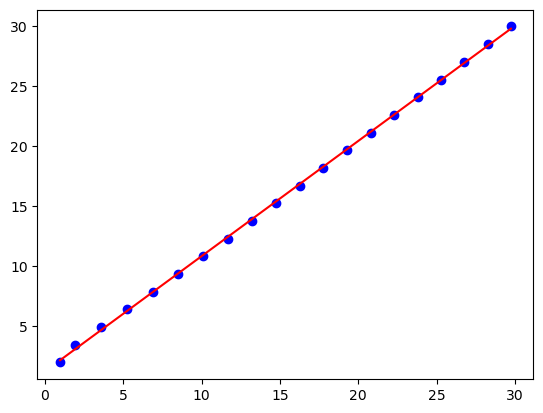

In [9]:
n = 1
coeffs = np.polyfit(np.abs(weight_sigmas[~np.isnan(weight_sigmas)]), original_sizes[~np.isnan(weight_sigmas)], n)
f = Polynomial(coeffs[::-1])  # reverse order

# Evaluate
x_new = np.linspace(np.nanmin(np.abs(weight_sigmas)), np.nanmax(np.abs(weight_sigmas)), 100)
y_fit = f(x_new)
plt.scatter(np.abs(weight_sigmas), original_sizes, color='blue')
plt.plot(x_new, y_fit, color='red')
plt.show()

In [10]:
y = np.arange(image.shape[0])
x = np.arange(image.shape[1])
x, y = np.meshgrid(x, y)

# Flatten image and coordinates
xdata = np.vstack((x.ravel(), y.ravel()))
ydata = image.ravel()

amplitude_guess = np.mean(image)
sigma_guess = 3

initial_guess = [amplitude_guess, sigma_guess]

In [11]:
size = 60
aperture_size = np.full(len(x_c), np.nan)
mask = (~np.isnan(x_c)) & (~np.isnan(y_c))
for i, (x_center, y_center) in enumerate(zip(x_c[mask], y_c[mask])):
    if i % 2500 == 0:
        print(i)

    x0 = int(round(x_center))
    y0 = int(round(y_center))

    # bounds (clip to image)
    x_min = max(0, x0 - size//2)
    x_max = min(nx, x0 + size//2 + 1)
    y_min = max(0, y0 - size//2)
    y_max = min(ny, y0 + size//2 + 1)

    cutout = image[y_min:y_max, x_min:x_max]

    # local coordinate grid
    y, x = np.mgrid[y_min:y_max, x_min:x_max]

    # fit only the cutout
    try:
        popt, _ = curve_fit(
            lambda xy, A, s: gaussian_2d(xy, A, s, x_center, y_center),
            (x, y),
            cutout.ravel(),
            p0=initial_guess
        )
        aperture_size[i] = np.abs(popt[1])
    except RuntimeError:
        continue

0
2500
5000
7500
10000
12500
15000


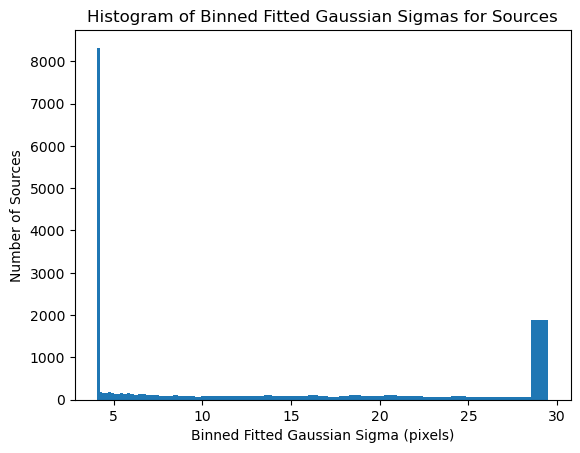

In [12]:
bins = np.logspace(np.log10(4), np.log10(30), 60)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# prepare array
sigma_binned = np.full_like(aperture_size, np.nan, dtype=float)

# mask valid (non-NaN) entries
mask = ~np.isnan(aperture_size)

# digitize only valid entries
bin_idx = np.digitize(aperture_size[mask], bins) - 1
bin_idx = np.clip(bin_idx, 0, len(bin_centers) - 1)

# assign binned values
sigma_binned[mask] = bin_centers[bin_idx]
plt.hist(sigma_binned[~np.isnan(sigma_binned)], bins=bin_centers)
plt.xlabel('Binned Fitted Gaussian Sigma (pixels)')
plt.ylabel('Number of Sources')
plt.title('Histogram of Binned Fitted Gaussian Sigmas for Sources')
plt.show()

In [13]:
fluxes = {}

fluxes['ra'] = ra_reference
fluxes['dec'] = dec_reference
fluxes['aperture_size'] = f(aperture_size)
rubin_filters = ['u', 'g', 'r', 'i', 'z', 'y']
euclid_filters = ['VIS', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
for filter in rubin_filters:
    fluxes[f'flux_{filter}'] = np.full_like(ra_reference, np.nan)
    fluxes[f'flux_{filter}_sigma'] = np.full_like(ra_reference, np.nan)

for filter in euclid_filters:
    fluxes[f'flux_{filter}'] = np.full_like(ra_reference, np.nan)
    fluxes[f'flux_{filter}_sigma'] = np.full_like(ra_reference, np.nan)

Processing filter: u


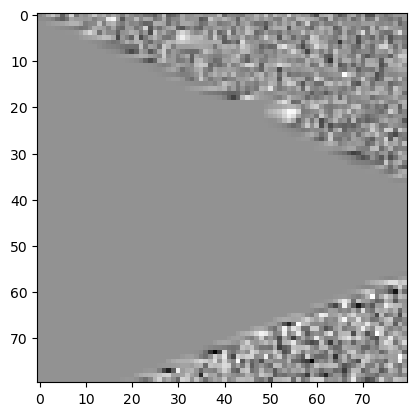

0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: g


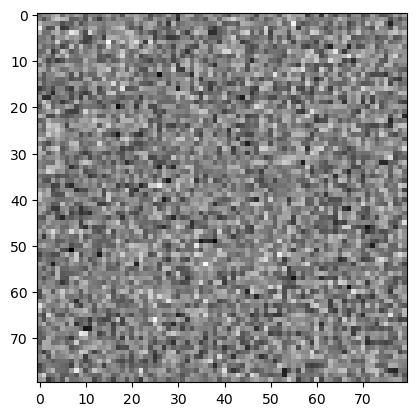

0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: r


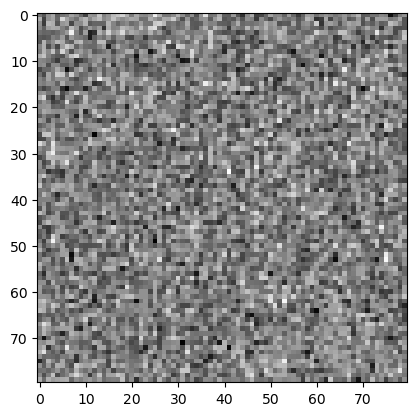

0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: i


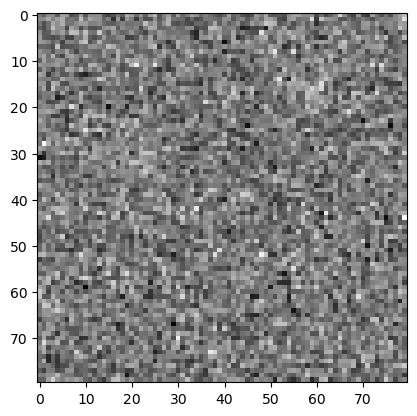

0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: z


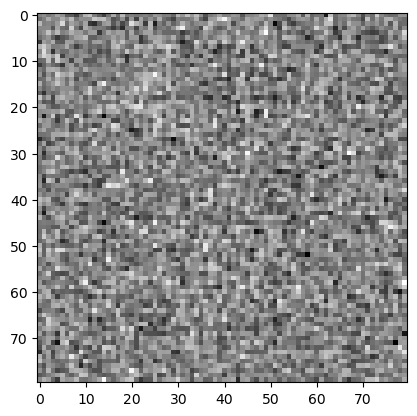

0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: y


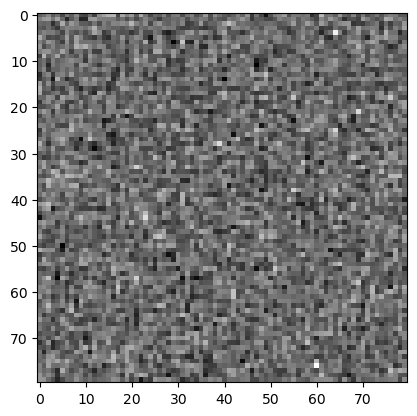

0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000


In [ ]:
size = 64
maxlag = 0
for filter in rubin_filters:
    print(f'Processing filter: {filter}')
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]
    psf_file = [f for f in files if f.endswith("psf.fits")][0]

    with fits.open(image_file, memmap=True) as hdul:
        hdu = hdul[1]
        image = hdu.data
        wcs = WCS(hdu.header)
        nx = hdu.header["NAXIS1"]
        ny = hdu.header["NAXIS2"]
    
    noise_cutout = find_noise_square(image, 80, 1)
    plt.imshow(noise_cutout, cmap='gray')
    plt.show()
    
    with fits.open(psf_file) as hdul:
        psf = hdul[0].data
    
    x_c, y_c = wcs.wcs_world2pix(ra_reference, dec_reference, 0, ra_dec_order=True)
    mask = (x_c >= 0) & (x_c < nx) & (y_c >= 0) & (y_c < ny) & (~np.isnan(fluxes['aperture_size']))

    cache = prepare_wiener_psf(psf, [size, size])
    for i, (x_center, y_center, valid) in enumerate(zip(x_c, y_c, mask)):
        if i % 2500 == 0:
            gc.collect()
            print(i)
        if not valid:
            continue
        cutout, new_center = padded_cutout_with_center(image, x_center, y_center, size)
        weight = gaussian_weight(size, size, size/2, size/2, fluxes['aperture_size'][i])
        flux, weight_rescale = calculate_gaap_flux(cutout, cache, weight, [new_center])
        sigma = estimate_sigma(noise_cutout, weight_rescale, maxlag)
        fluxes[f'flux_{filter}'][i] = flux[0]
        fluxes[f'flux_{filter}_sigma'][i] = sigma

Processing filter: VIS


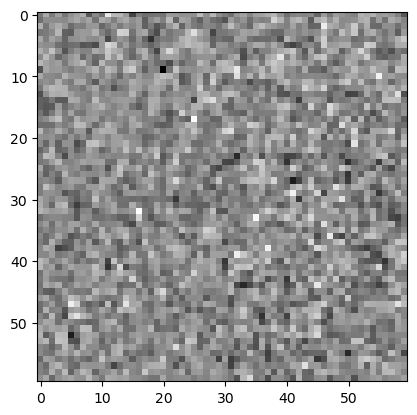

Creating PSF...
0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: DES-G


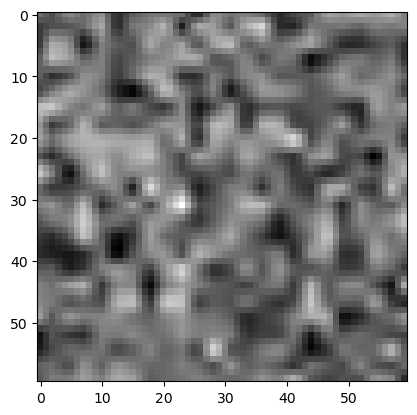

Creating PSF...
0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: DES-R


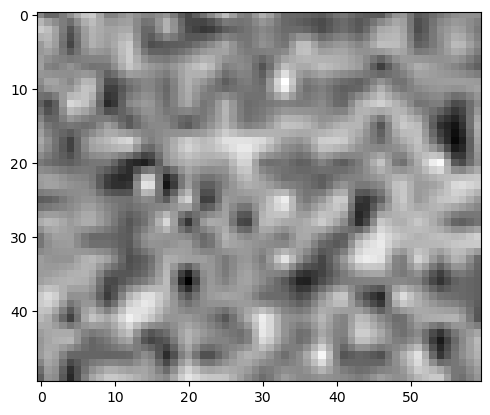

Creating PSF...
0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: DES-I


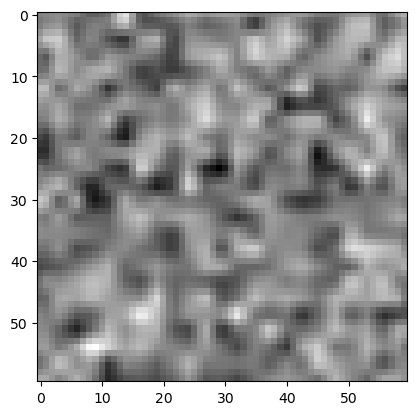

Creating PSF...
0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: NIR-Y


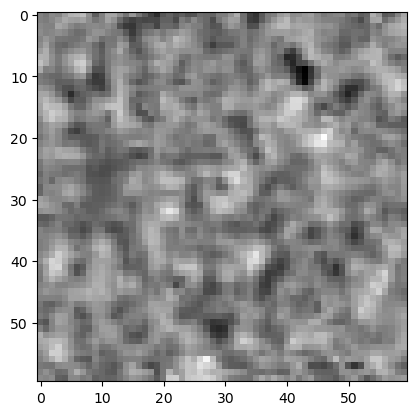

Creating PSF...
0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: NIR-J


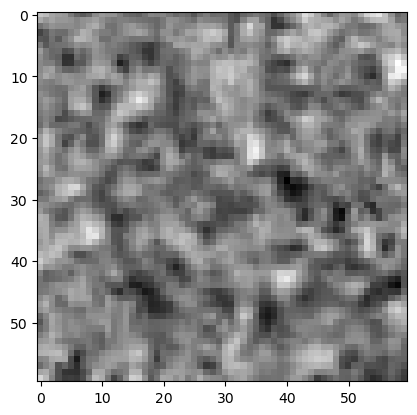

Creating PSF...
0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000
Processing filter: NIR-H


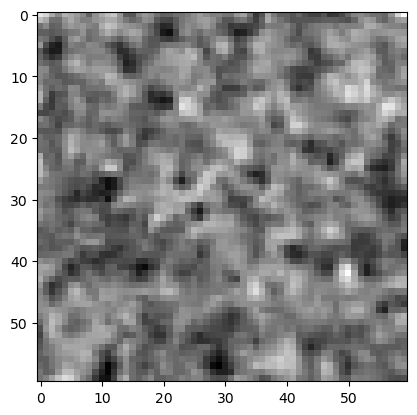

Creating PSF...
0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
102500
105000
107500
110000


In [ ]:
euclid_size = 2 * size
maxlag = 0
for filter in euclid_filters:
    print(f'Processing filter: {filter}')
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]

    with fits.open(image_file, memmap=True) as hdul:
        hdu = hdul[0]
        image = hdu.data
        wcs = WCS(hdu.header)
        nx = hdu.header["NAXIS1"]
        ny = hdu.header["NAXIS2"]
        zeropoint = hdu.header["MAGZERO"]
        conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 10**9
        image *= conversion_factor
    
    noise_cutout = find_noise_square(image[:3400, :3400], 60, 1) * conversion_factor
    plt.imshow(noise_cutout, cmap='gray')
    plt.show()
    
    x_c, y_c = wcs.wcs_world2pix(ra_reference, dec_reference, 0, ra_dec_order=True)
    mask = (x_c >= 0) & (x_c < nx) & (y_c >= 0) & (y_c < ny) & (~np.isnan(fluxes['aperture_size']))

    print('Creating PSF...')
    catalog = Table.read(f'{location}/{field}/{filter}.cat', format="fits", hdu=2)
    psf = create_psf(image, catalog, euclid_size)

    cache = prepare_wiener_psf(psf, [euclid_size, euclid_size])
    for i, (x_center, y_center, valid) in enumerate(zip(x_c, y_c, mask)):
        if i % 2500 == 0:
            gc.collect()
            # print(i)
        if not valid:
            continue
        cutout, new_center = padded_cutout_with_center(image, x_center, y_center, euclid_size)
        cutout *= conversion_factor
        weight = gaussian_weight(euclid_size, euclid_size, euclid_size/2, euclid_size/2, 2 * fluxes['aperture_size'][i])
        flux, weight_rescale = calculate_gaap_flux(cutout, cache, weight, [new_center])
        sigma = estimate_sigma(noise_cutout, weight_rescale, maxlag)
        fluxes[f'flux_{filter}'][i] = flux[0]
        fluxes[f'flux_{filter}_sigma'][i] = sigma

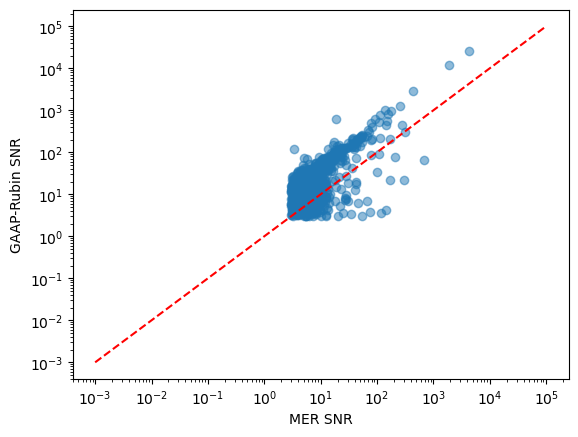

Percent of sources where GAAP-Rubin SNR > MER SNR: 0.884263959390863
Average SNR improvement factor (GAAP-Rubin / MER): 3.355719086995486


In [21]:
snr_meer = cat['FLUX_G_EXT_DECAM_4FWHM_APER'] / cat['FLUXERR_G_EXT_DECAM_4FWHM_APER']
snr_gaap = fluxes['flux_g']/fluxes['flux_g_sigma']
cutoff_snr = 3
mask = (snr_meer > cutoff_snr) & (snr_gaap > cutoff_snr) & (np.isfinite(snr_gaap)) & (np.isfinite(snr_meer))
plt.scatter(snr_meer[mask],
            snr_gaap[mask],
            alpha=0.5)
plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
plt.xlabel('MER SNR')
plt.ylabel('GAAP-Rubin SNR')
plt.loglog()
plt.show()
print("Percent of sources where GAAP-Rubin SNR > MER SNR:", np.nansum(snr_gaap[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap[mask])))
print("Average SNR improvement factor (GAAP-Rubin / MER):", np.nanmean(snr_gaap[mask] / snr_meer[mask]))

In [ ]:
# df = pd.read_csv(f'/net/vdesk/data2/deklerk/GAAP_data/{field}/fluxes.csv')

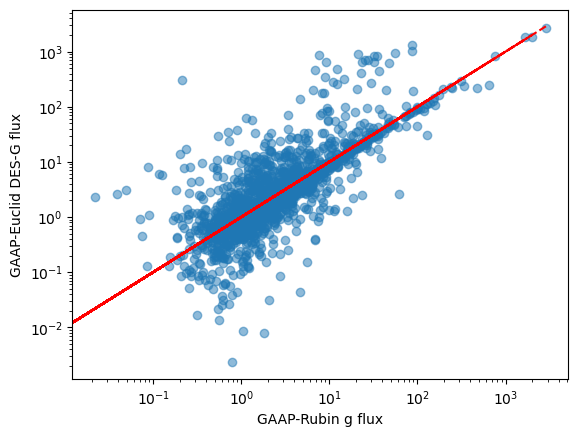

In [25]:
plt.scatter(fluxes['flux_g'], fluxes['flux_DES-G'], alpha=0.5)
plt.plot(fluxes['flux_g'], fluxes['flux_g'], 'r--')
plt.xlabel('GAAP-Rubin g flux')
plt.ylabel('GAAP-Euclid DES-G flux')
plt.loglog()
plt.show()

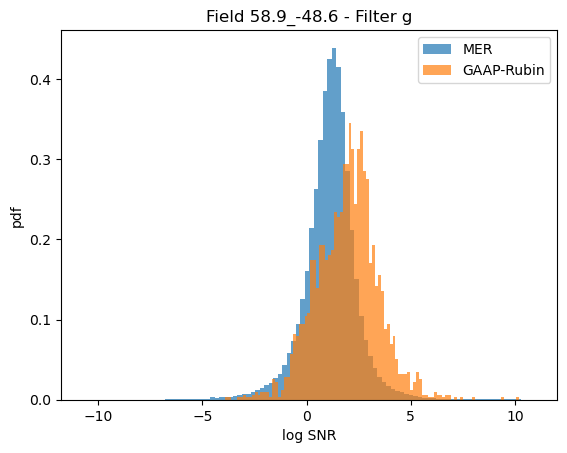

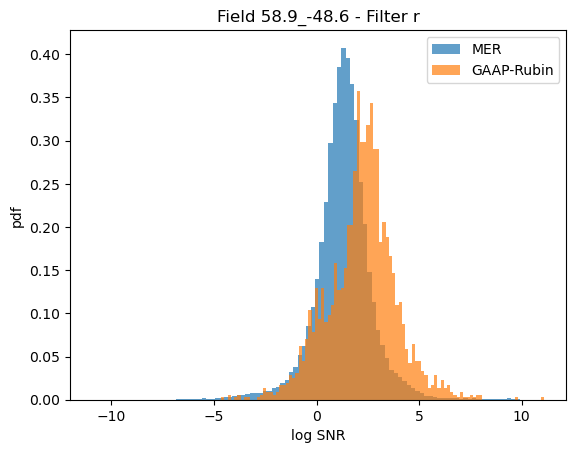

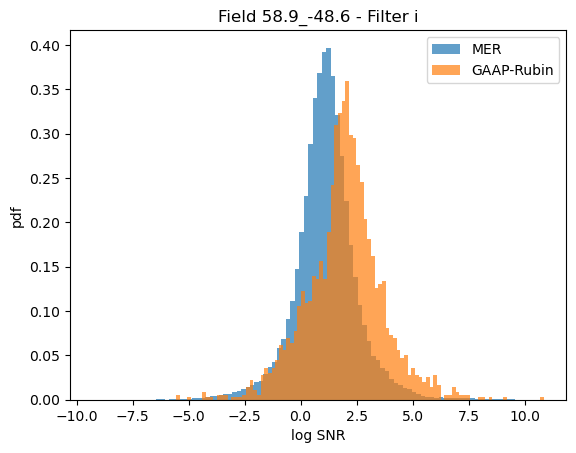

In [26]:
for filter in ['g', 'r', 'i']:
    plt.hist(np.log(cat[f'FLUX_{filter.upper()}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter.upper()}_EXT_DECAM_4FWHM_APER']), bins=100, density=True, alpha=0.7, label='MER')
    plt.hist(np.log(fluxes[f'flux_{filter}'][fluxes[f'flux_{filter}']>0]/fluxes[f'flux_{filter}_sigma'][fluxes[f'flux_{filter}']>0]), bins=100, density=True, alpha=0.7, label='GAAP-Rubin')
    # plt.hist(np.log(fluxes['DES-G'][fluxes['DES-G']>0]/fluxes['DES-G_sigma'][fluxes['DES-G']>0]), bins=100, density=True, alpha=0.7, label='GAAP-Euclid')
    plt.title(f'Field {field} - Filter {filter}')
    plt.xlabel('log SNR')
    plt.ylabel('pdf')
    plt.legend()
    plt.show()

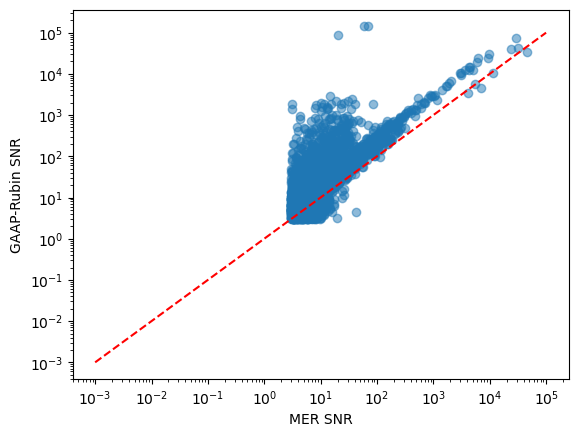

Percent of sources where GAAP-Rubin SNR > MER SNR: 0.890058155635558
Average SNR improvement factor (GAAP-Rubin / MER): 4.7510536186572985


In [ ]:
snr_meer = cat['FLUX_G_EXT_DECAM_4FWHM_APER'] / cat['FLUXERR_G_EXT_DECAM_4FWHM_APER']
snr_gaap = df['flux_g']/df['flux_g_sigma']
# snr_meer = fluxes['flux_g']/fluxes['flux_g_sigma']
cutoff_snr = 3
mask = (snr_meer > cutoff_snr) & (snr_gaap > cutoff_snr) & (np.isfinite(snr_gaap)) & (np.isfinite(snr_meer))
plt.scatter(snr_meer[mask],
            snr_gaap[mask],
            alpha=0.5)
plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
plt.xlabel('MER SNR')
plt.ylabel('GAAP-Rubin SNR')
plt.loglog()
plt.show()
print("Percent of sources where GAAP-Rubin SNR > MER SNR:", np.nansum(snr_gaap[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap[mask])))
print("Average SNR improvement factor (GAAP-Rubin / MER):", np.nanmean(snr_gaap[mask] / snr_meer[mask]))

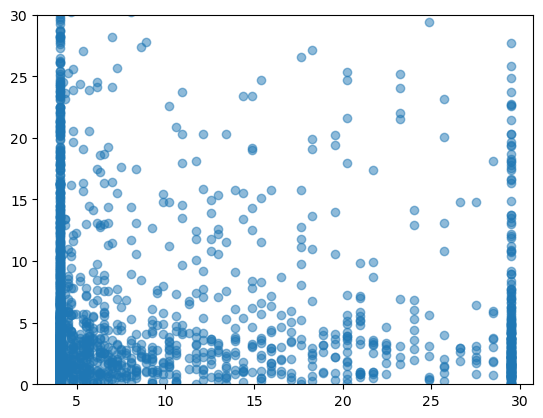

In [ ]:
mask = (np.isfinite(df['binned_sigma'].values)) & (np.isfinite(fluxes['aperture_size']))
plt.scatter(df['binned_sigma'][mask], fluxes['aperture_size'][mask], alpha=0.5)
plt.ylim(0, 30)
plt.show()